In [2]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

In [4]:
sess = tf.compat.v1.Session()

c = tf.constant(3.0)
print(sess.run(c))

3.0


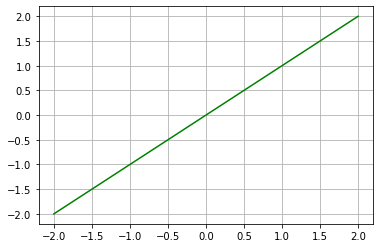

In [24]:
x = np.linspace(-2, 2, 1000)
y = np.linspace(-2, 2, 1000)
# print(x)

plt.grid(True)
plt.plot(x,y,'g')

In [12]:

import math
import numpy as np
e = math.e
    
def run_step(p_x, p_type_str):
    x = tf.constant(float(p_x))

    # @tf.function 
    def t(p_x):
        
        if p_type_str == "sigmoid":
            # sigmoid activation fun - 1/(1+e^-x)
            y = 1/(1 + e**-p_x)
            # y = tf.math.sigmoid(i)
        
        elif p_type_str == "tanh":
            # hyperbolic tangent fun - (e^x - e^-x)/(e^x+e^-x)
            y = (e**p_x - e**-p_x) / (e**p_x + e**-p_x)
            # y = tf.math.tanh(p_x)
        
        elif p_type_str == "relu":
            # ReLU - Rectified Linear Unit - max(0, x)
            if sess.run(p_x) > 0: y = p_x
            else:                 y = 0.0 * p_x
            # y = tf.nn.relu(p_x)
        
        return y
        
    

    with tf.GradientTape() as g:
        g.watch(x)
        # g.watch(y)
        
        # y = tf.math.sigmoid(x)
        # y = tf.py_function(func=t, inp=[p_x], Tout=tf.float32) # (e**p_x - e**-p_x) / (e**p_x + e**-p_x)
        y = t(x)
        
        target = y # tf.convert_to_tensor(y)
        source = x
        dy_dx  = g.gradient(target, source)
    return y, dy_dx

In [13]:
sess = tf.compat.v1.Session()



for x in range(0, 3):
    _, dy_dx = run_step(x, "tanh")
    print(sess.run(dy_dx))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
0.24999999
0.19661193
0.10499358


In [154]:
def run_test(p_type_str):
    sess = tf.compat.v1.Session()

    x_lst = [] # np.geomspace(-2, 2, 10)
    y_lst = []
    dy_dx_lst = []

    import time

    input_lst = np.arange(-5, 5, 0.2)
    for i in range(0, len(input_lst)):
        x = input_lst[i]

        t1 = time.time()

        y, dy_dx = run_step(x, p_type_str)
        d        = sess.run(dy_dx)
        # print(d)



        x_lst.append(x)

        y_val = sess.run(y)
        y_lst.append(y_val)

        dy_dx_lst.append(d)

        # print(x_lst)
        # print(y_lst)
        # print(dy_dx_lst)

        t2 = time.time()
        print("%s/%s - %ss"%(i, len(input_lst), t2-t1))

    plt.grid(True)
    plt.plot(x_lst, y_lst, "g")
    plt.plot(x_lst, dy_dx_lst, "r")

0/50 - 2.8431553840637207s
1/50 - 2.9345009326934814s
2/50 - 2.932145595550537s
3/50 - 2.999871253967285s
4/50 - 3.1286845207214355s
5/50 - 3.091639995574951s
6/50 - 2.9675064086914062s
7/50 - 3.068392276763916s
8/50 - 2.932551145553589s
9/50 - 2.8349173069000244s
10/50 - 2.9446358680725098s
11/50 - 2.9367997646331787s
12/50 - 2.9339141845703125s
13/50 - 3.0100367069244385s
14/50 - 3.1107177734375s
15/50 - 3.102998971939087s
16/50 - 3.0769717693328857s
17/50 - 2.998762845993042s
18/50 - 3.2091238498687744s
19/50 - 3.441526412963867s
20/50 - 3.274153709411621s
21/50 - 3.135399341583252s
22/50 - 3.060608148574829s
23/50 - 2.9247543811798096s
24/50 - 3.160015821456909s
25/50 - 3.0058767795562744s
26/50 - 2.931903839111328s
27/50 - 3.1069788932800293s
28/50 - 2.9090237617492676s
29/50 - 3.1193525791168213s
30/50 - 2.890469551086426s
31/50 - 3.0147294998168945s
32/50 - 2.988379955291748s
33/50 - 2.9652915000915527s
34/50 - 2.96937894821167s
35/50 - 3.057140588760376s
36/50 - 2.9847819805145

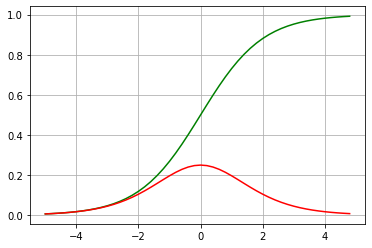

In [156]:
run_test("sigmoid")

0/50 - 2.900290012359619s
1/50 - 2.999386787414551s
2/50 - 3.0536813735961914s
3/50 - 3.0227138996124268s
4/50 - 2.9659628868103027s
5/50 - 3.00416898727417s
6/50 - 3.029707670211792s
7/50 - 3.121809720993042s
8/50 - 3.0761871337890625s
9/50 - 3.1806631088256836s
10/50 - 3.3004560470581055s
11/50 - 3.0840611457824707s
12/50 - 3.074636459350586s
13/50 - 3.072382926940918s
14/50 - 3.0765480995178223s
15/50 - 3.130251407623291s
16/50 - 3.04445481300354s
17/50 - 3.087456703186035s
18/50 - 3.037914514541626s
19/50 - 3.0250842571258545s
20/50 - 3.1892664432525635s
21/50 - 3.3776509761810303s
22/50 - 3.319929361343384s
23/50 - 3.2174863815307617s
24/50 - 3.1818294525146484s
25/50 - 3.221303701400757s
26/50 - 3.3188376426696777s
27/50 - 3.0871071815490723s
28/50 - 3.110757350921631s
29/50 - 3.2453033924102783s
30/50 - 3.2856578826904297s
31/50 - 3.111389398574829s
32/50 - 3.1179301738739014s
33/50 - 3.1504688262939453s
34/50 - 3.1249923706054688s
35/50 - 3.0869240760803223s
36/50 - 3.161593198

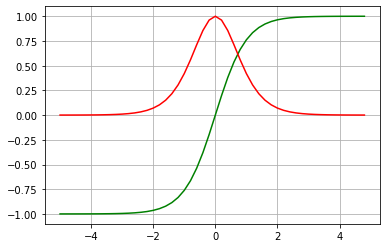

In [157]:
run_test("tanh")

0/50 - 5.322201490402222s
1/50 - 5.2376837730407715s
2/50 - 5.204629182815552s
3/50 - 5.209854602813721s
4/50 - 5.6322340965271s
5/50 - 5.369730234146118s
6/50 - 5.259985685348511s
7/50 - 5.252997398376465s
8/50 - 5.605458498001099s
9/50 - 5.319669008255005s
10/50 - 5.425795793533325s
11/50 - 5.558258533477783s
12/50 - 5.574413537979126s
13/50 - 5.2905871868133545s
14/50 - 5.2599427700042725s
15/50 - 5.357506513595581s
16/50 - 5.198545932769775s
17/50 - 5.311051845550537s
18/50 - 5.4887707233428955s
19/50 - 5.465182065963745s
20/50 - 5.62846302986145s
21/50 - 5.592763900756836s
22/50 - 5.47521185874939s
23/50 - 5.673851490020752s
24/50 - 5.515314817428589s
25/50 - 5.568107843399048s
26/50 - 5.549628973007202s
27/50 - 5.485443830490112s
28/50 - 5.700120687484741s
29/50 - 5.556420803070068s
30/50 - 5.345186471939087s
31/50 - 5.3015289306640625s
32/50 - 5.296907901763916s
33/50 - 5.315702199935913s
34/50 - 5.265882253646851s
35/50 - 5.331820726394653s
36/50 - 5.313354015350342s
37/50 - 5.

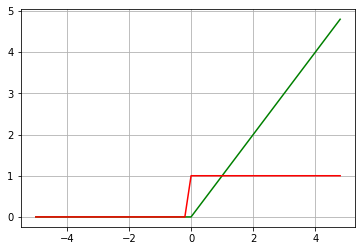

In [158]:
run_test("relu")